
This report is our (Ethan Douglas, Nick Wan) submission for the 2021 NFL Big Data Bowl. We utilized the data provided to build two models: Throw likelihood  and Target Receiver Probability. Together these models can help evaluate defensive performance on passing plays. Specifically, we believe our analysis has filled the following gaps:

* Developed a novel method to evaluate the ability of individual defenders to prevent targets.
* Identified the league's top "shutdown" cornerbacks in 2018.
* Concluded that a shutdown defender may not be as valuable to a defense as previously thought.

Additionally, our target receiver probability model can be used by coaching staff for defensive game planning and opponent and self tendency scouting, as well as for future development of continous expected value models.
<a id='bg'></a>
<div class="h2">  Background</div>

The modern NFL is largely thought of as an offensive league. [Scheme innovations, rule changes, and better athletes](https://www.nytimes.com/2019/01/19/sports/nfl-offense-records.html) have all led to [all-time highs in points scored](https://www.pro-football-reference.com/years/NFL/scoring.htm). This increase in offensive efficiency has largely skewed toward the passing component of the game, so much so that the average quarterback in 2020 would look hall-of-fame worthy by 1980 standards.

This wave of more passing has been matched with an increase in the attempts to quantify the passing game, [from new quarterback-centric metrics](https://twitter.com/benbbaldwin/status/1187791411980259330?s=20) to [receiver route identification](https://arxiv.org/abs/1908.02423). However, few attempts have been made to quantify defensive performance. As passing becomes “easier”, innovation in the realm of pass defense is arguably more valuable than ever - and [in fact defensive pass Expected Points Allowed explains more of the variance in final regular season team point differential than rushing offense or rushing defense](https://twitter.com/EthanCDouglas/status/1346669660867973121?s=20). NFL front offices clearly feel defense matters as well, as [on average they spend just as much on the salaries of defensive players as they do on offensive players](https://twitter.com/EthanCDouglas/status/1346677118776659970?s=20).

Previous attempts have been made at quantifying individual pass defensive performance using tracking data ([1](https://fivethirtyeight.com/features/what-the-nfls-new-pass-defense-metric-can-and-cant-tell-us/), [2](https://twitter.com/SethWalder/status/1345550258483449857?s=20)) however these metrics have solely evaluated the performance of a pass defender when his nearest defender is targeted by the passing offense, and often only during a short window of the play (from time of throw to when the ball arrives). Not only is this a severely limited sample, but it is a biased one as well - a target is often only earned by a receiver if the quarterback is confident he can complete the throw, meaning we are potentially only evaluating a defender’s worst snaps. 

Our submission aims to improve on this limitation by establishing a methodology to evaluate individual defensive performance on all passing plays, through the duration of the coverage-portion of the play.

<a id='bg'></a>
<div class="h2">  Methodology</div>

In order to understand how to evaluate a defender on a play, our analysis began by watching [NFL Game Pass Film Sessions](https://gamepass.nfl.com/category/nfl-game-pass-film-session), noting important concepts taught by coaches or players. These takeaways formed the basis for our analyses, and a few are described briefly below.

The goal of the defense is to stop the offense from scoring points, but the individual goal of each defender is not so straightforward. Sometimes they are in “man” coverage where their goal is to tightly follow their “man” throughout the play, other times they are in “zone” where instead of shadowing a specific receiver, they defend a designated area of the field. One of our key takeaways from these film sessions was that it can be incredibly difficult for even a highly experienced football expert to determine the assignment of an individual player while watching the film, unless they have inside knowledge of the system and playcall. To complicate things further, Steve Spagnuolo, the current Defensive Coordinator for the Kansas City Chiefs, [noted that there is a high prevalence of pattern matching](https://gamepass.nfl.com/video/coach-steve-spagnuolo) in today’s NFL. [Pattern matching is a defensive scheme in which the defenders may adapt their assignment as the play develops, often shifting between “man” and “zone” assignment](https://theathletic.com/2275485/2020/12/22/defense-coverages-types-man-zone/). This led us to the conclusion that attempting to identify a player’s assignment through one year of location data would likely just add noise to whatever metric we develop.

Instead, we chose to assign each receiver to a nearest defender throughout the play, and use that nearest defender as our proxy for “assignment.” This has important implications for the interpretation of our results, which is discussed in a later section of the report. 

An additional takeaway from studying these film sessions was that defensive backs spend immense effort studying tendencies in order to predict the primary target (who the offense would like to receive the pass) of the upcoming play, and this knowledge influences how they defend during the play. Former-first round pick Tre'Davious noted this specifically when he was matched up against All-pro Odell Beckham: [“When he’s off-ball… 9 times out of ten the ball is probably going to him.”](https://youtu.be/jvb6FEnKst4?t=260)

This thorough review of expert testimony led us to develop the below framework of how we perceive a defensive back approaches coverage. 

* Stage 1 - Decrease probability of QB targeting your assignmnet
* Stage 2 - Decrease probability of QB completing a pass to your aassignment
* Stage 3 - Decrease expected value of possession by making a tackle if the receiver does catch the ball

The bulk of previous research on defensive coverage has primarily focused on stage 2 (decreasing catch probability), but stage 1 (decreasing chance of a pass to your player) has been largely neglected. 

While a full evaluation of individual defensive performance likely requires a measurement at all 3 stages of this framework, we have chosen to focus this report on Stage 1: Decreasing the probability of the QB targeting your assignment.

<a id='bg'></a>
<div class="h3">  Data Analysis</div>

In order to evaluate how well individual defenders prevented targets to their nearest receiver, we built two models. This models rely only on the provided play-level tracking dataset, as well as the supplemental targeted receiver ID data.

<a id='bg'></a>
<div class="h4">  Target Receiver Probability</div>

Of the X pass plays included in the data set, Y were used to train the target receiver probability model. Plays were filtered that included multiple QBs and plays that did not have a pass attempt. To reduce training time, the model was only trained on frames which included the following events:
* Snap
* Pass throw
* Pass Arrival (Pass outcome frame was used if no pass arrival frame was identified)

We extracted the following chip-based features for the target receiver probability model:

* QB orientation
* QB X position
* QB y position
* Receiver X location
* Receiver distance from sideline
* Receiver distance from football
* Receiver distance from nearest defender
* Football distance from QB
* Football distance from nearest defender
* QB distance from nearest defender

These features allow for an exact triangulation of the position of the QB, football, receiver, and nearest defender, without needing the X and Y location of every player on the field. 

Additionally, we used the following contextual features, all of which are potentially accounted for in the mental model of a defensive back prior to the snap:

* Line of scrimmage
* Down
* Distance 
* Receiver target share (the proportion of their team’s targets a given receiver has received thus far into the season)

We experimented with four different models for predicting target receiver probability with these features: naive (predict the average target probability for every receiver), a linear model, random forest, and a gradient boosted deicision tree-based model.

We validated these models through grouped k-fold crossvalidation. Because the model is trained on many frames from each play, the it was essential that we group the data in such a way that all frames from the same play ended in the same fold - otherwise we risked severely overfitting and simply "memorizing" the presnap formation for each play.

We ended up choosing the gradient boosted decision tree-based model as it had the highest out-of-sample accuracy (59%) and log loss (0.94), both of which were significant improvements on the naive model (accuracy = 21%, log loss = 1.61).

Below is example play footage with corresponding target probability.

<img src="https://media.giphy.com/media/RYLC0OUc8buVb5CGOG/giphy.gif">

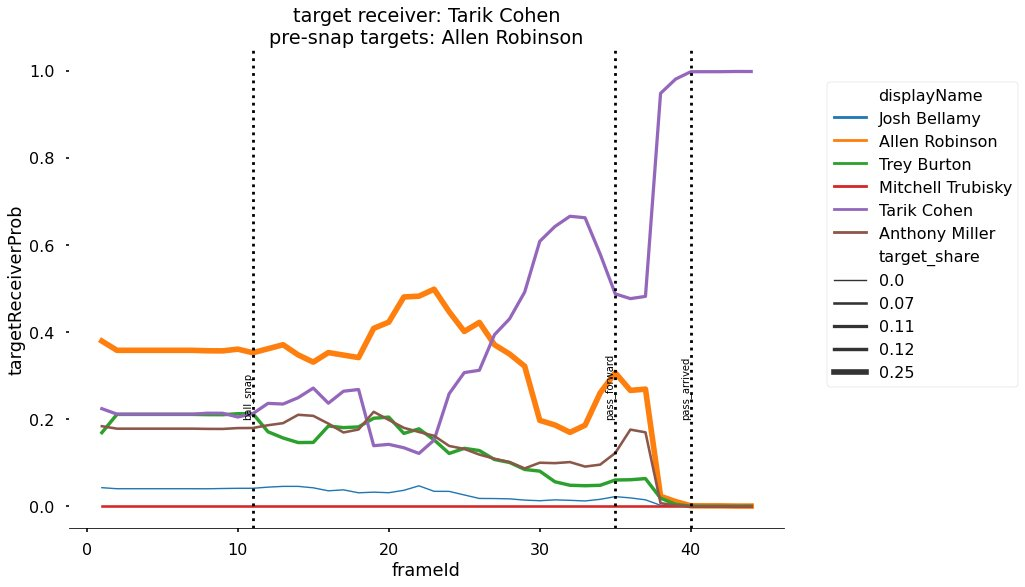


<a id='bg'></a>
<div class="h2">  Player Evaluation</div>

There are many ways in which the outputs of our true target probability model can be leveraged to evaluate individual defensive players, however for the purpose of this report we will focus on targets prevented over expected (TPOE).

By summing up the presnap assignment target probability of a defender, we can determine their expected targets for the season.

Next, we quantify targets over expected - how many times a the nearest receiver to a defender was targeted subtracted from their expected targets.

Our hypothesis was that skilled defensive backs would be expected to earn lots of targets because of their high usage, but end up earning fewer targets than average - in other words they would prevent targets or "shutdown" their receiver more often than average.

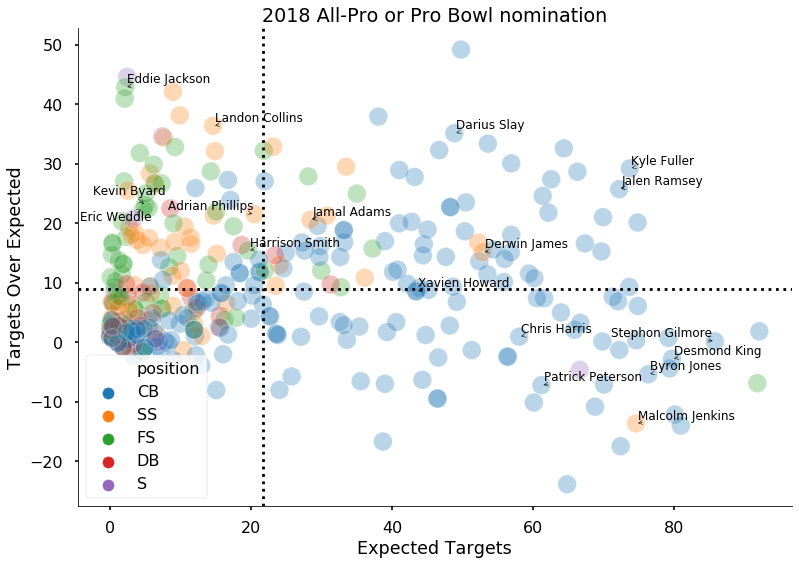

This theory bears out for many of the all-pro or pro bowl nominated players we have highlighted above. Stephon Gilmore, Desmond King, Byron Jones all prevented their nearest defenders from earning targets more often than average.

However, a couple of commonly perceived top cornerbacks - Jalen Ramsey, and Kyle Fuller - actually allowed more targets than expected. This is likely not an indictment on their overall skill, as we are intentionally only measuring one component of defensive back performance here. Good coverage players must still decrease the likelihood of a completion once their player is targeted, which Ramsey and Fuller may excel at. 

Additionally, this metric seems to far less successful at identifying skilled linebackers or safeties as it is for cornerbacks. This is likely due to the way we are "assigning" a defender to a nearest receiver, rather than their true assignment on a play. A skilled safety or linebacker who are more likely to be in a "zone" defense may successfuly identify targets before they happen and become a nearest defender to that receiver despite that target not being their "fault." Without a player's role being taken into account, we must be cautious in how we compare players with different roles or positions. 

Given that this metric is likely best used for cornerbacks, we decided to explore the value a target-preventing cornerback adds to their team. How does defensive passing performance correlate to the Targets Prevented Over Expected (TPOE) of their top cornerback?

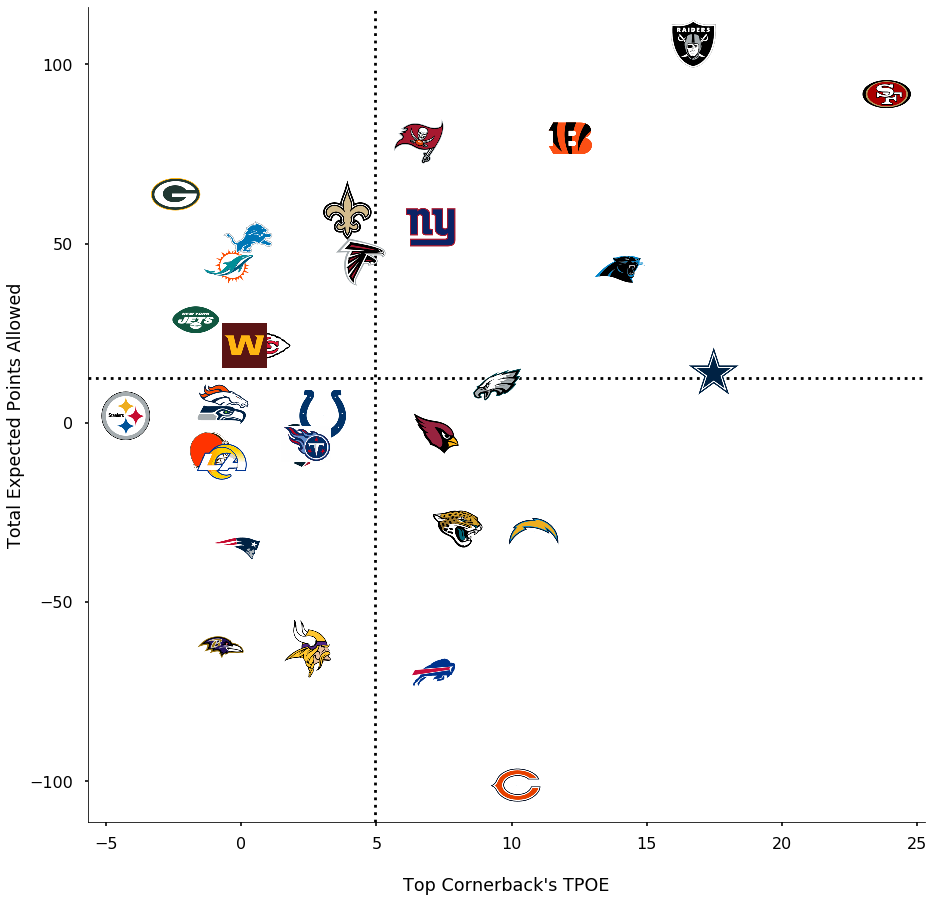

Not very well. In fact, the teams with the highest rated top cornerbacks (49ers, Cowboys, Raiders) all had below average pass defenses. While this may be surprising, it is actually somewhat intuitive. Because the offense decides who they target on every play, a defensive may only be as good as their weakest defender. This is known as a weak-link system, and [previous research](https://www.pff.com/news/nfl-how-fragile-is-defense-a-look-ateffect-of-stars-versus-depth-on-game-outcomes) has identified NFL defenses as having this characterstic. This additional evidence may be reason for teams to reevaluate how much value a single "shutdown" cornerback adds - at least as it relates to their ability to prevent targets to their assignment.



<a id='bg'></a>
<div class="h2"> Conclusion</div>

There is still much more work to be done in order to fully evaluate the performance or contribution of individual defensive players. However, our analysis shows that a target probability model can potentially be used to find players who successfuly prevent the their receiver from earning a chance to make a catch.

Our proposed target probability model can be used by coaching staffs in order to scout tendencies in their opponents (or themselves). This model relied on positional data, however we know that players use more nuanced "tells" to determine target probability, such as the stance of a wide receiver. Future work could explore augmenting a location-based target probability model with more qualtitative charting data, which would increase its value for gameplanning.

Additionally, we believe there is immense value in a continous-time assesment of a play's expected value, especially as it relates to the ability to weight and value a player's contributions throughout a play. [Researchers have previously built components of such a model with NFL applications](http://www.stat.cmu.edu/~ryurko/publication/goingdeep/), and our target probability model could be a building block for future research on this topic.












[code](https://github.com/ArrowheadAnalytics/BDB21)